In [16]:
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score,)
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [17]:
dataset = pd.read_csv('datasets\story_emotion3.csv', encoding='ISO-8859-1')
stopword = pd.read_csv('datasets\stopwords_tl.csv')
stopwords_set = set(stopword['stopword'])
stemmer = pd.read_csv('datasets\stem_tl.csv')
word_to_stem = dict(zip(stemmer['word'], stemmer['stem']))

class_names = {
    1: 'fear',
    2: 'anger',
    3: 'joy',
    4: 'sadness',
    5: 'disgust',
    6: 'surprise'
}

replace_patterns = {
    re.compile(r"\bngayo\'y\b"): 'ngayon ay',
    re.compile(r"\bhangga\'t\b"): 'hanggang',
    re.compile(r"\b\'?y\b"): ' ay',
    re.compile(r"\b\'?t\b"): ' at',
    re.compile(r"\b\'?yan\b"): 'iyan',
    re.compile(r"\b\'?yo\b"): 'iyo',
    re.compile(r"\b\'?yon\b"): 'iyon',
    re.compile(r"\b\'?yun\b"): 'iyun',
    re.compile(r"\b\'?pagkat\b"): 'sapagkat',
    re.compile(r"\b\'?di\b"): 'hindi',
    re.compile(r"\b\'?kaw\b"): "ikaw",
    re.compile(r"\b\'?to\b"): 'ito',
    re.compile(r"\b\'?wag\b"): 'huwag',
    re.compile(r"\bgano\'n\b"): 'ganoon'
}

def data_preprocess(text, replace_patterns, word_to_stem, stopwords_set):
    text = text.lower()

    for pattern, replacement in replace_patterns.items():
        text = pattern.sub(replacement, text)

    text = re.sub("[^a-zA-Z0-9\s?!]", '', text)
    tokens = word_tokenize(text)
    text = ' '.join([word_to_stem.get(word, word) for word in tokens if word.lower() not in stopwords_set])

    return text

dataset['text'] = dataset['text'].apply(data_preprocess, replace_patterns=replace_patterns, word_to_stem=word_to_stem, stopwords_set=stopwords_set)

X = dataset['text']
Y = dataset['emotion']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vectorized)
X_test_tfidf = tfidf_transformer.transform(X_test_vectorized)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, Y_train)
Y_pred = nb_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))

Accuracy: 0.717741935483871

Classification Report:
               precision    recall  f1-score   support

        fear       0.50      0.75      0.60        20
       anger       0.65      0.71      0.68        21
         joy       0.73      0.76      0.74        21
     sadness       0.81      0.62      0.70        21
     disgust       0.93      0.70      0.80        20
    surprise       0.89      0.76      0.82        21

    accuracy                           0.72       124
   macro avg       0.75      0.72      0.72       124
weighted avg       0.75      0.72      0.73       124



In [18]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False],
}

grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, Y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'alpha': 0.5, 'fit_prior': False}
Best Accuracy:  0.6989898989898989


In [19]:
nb_classifier = MultinomialNB(alpha=1.5,fit_prior='True')
nb_classifier.fit(X_train_tfidf, Y_train)

Y_pred = nb_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of MNB:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))

Accuracy of MNB: 0.717741935483871

Classification Report:
               precision    recall  f1-score   support

        fear       0.54      0.75      0.63        20
       anger       0.65      0.71      0.68        21
         joy       0.67      0.76      0.71        21
     sadness       0.81      0.62      0.70        21
     disgust       0.93      0.70      0.80        20
    surprise       0.89      0.76      0.82        21

    accuracy                           0.72       124
   macro avg       0.75      0.72      0.72       124
weighted avg       0.75      0.72      0.72       124



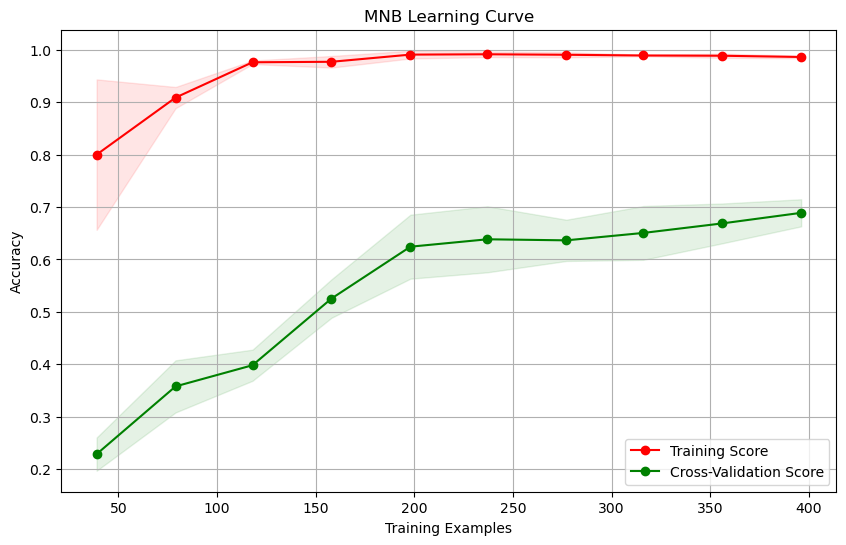

In [20]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    nb_classifier, X_train_tfidf, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("MNB Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X, Y)):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    X_train_vectorized_fold = vectorizer.fit_transform(X_train_fold)
    X_test_vectorized_fold = vectorizer.transform(X_test_fold)

    X_train_tfidf_fold = tfidf_transformer.fit_transform(X_train_vectorized_fold)
    X_test_tfidf_fold = tfidf_transformer.transform(X_test_vectorized_fold)

    nb_classifier = MultinomialNB(alpha=1.5,fit_prior='True')
    nb_classifier.fit(X_train_tfidf, Y_train)

    nb_classifier.fit(X_train_tfidf_fold, Y_train_fold)

    Y_pred_fold = nb_classifier.predict(X_test_tfidf_fold)

    accuracy_scores.append(accuracy_score(Y_test_fold, Y_pred_fold))
    precision_scores.append(precision_score(Y_test_fold, Y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(Y_test_fold, Y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(Y_test_fold, Y_pred_fold, average='weighted'))

print(f'Average Accuracy: {np.mean(accuracy_scores)}')
print(f'Average Precision: {np.mean(precision_scores)}')
print(f'Average Recall: {np.mean(recall_scores)}')
print(f'Average F1 Score: {np.mean(f1_scores)}')


Average Accuracy: 0.7220954628901127
Average Precision: 0.737309966430994
Average Recall: 0.7220954628901127
Average F1 Score: 0.7238926885105741


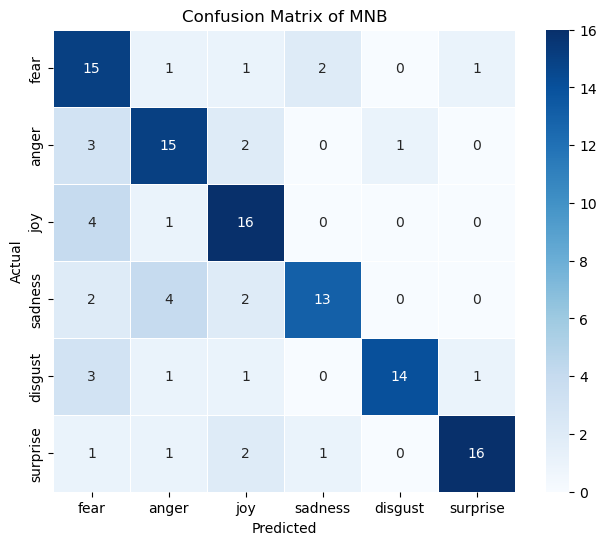

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(Y_test, Y_pred)

conf_df = pd.DataFrame(conf_matrix, index=class_names.values(), columns=class_names.values())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of MNB')
plt.show()
